# Cell2Fate analysis of mouse dentate gyrus dataset

This notebook demonstrates Cell2Fate analysis on the mouse dentate gyrus dataset.

Based on: https://cell2fate.readthedocs.io/en/latest/notebooks/publication_figures/cell2fate_DentateGyrus.html


In [2]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os

data_name = 'DentateGyrus'


## Set up data directories

You need to change this to suitable directories on your system:


In [3]:
# where to download data and where to save results
data_path = './data/DentateGyrus/'
results_path = './results/DentateGyrus/'

# Create directories if they don't exist
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)


## Download data


In [4]:
# Downloading data into specified directory:
os.system('cd ' + data_path + ' && wget -q https://cell2fate.cog.sanger.ac.uk/' + data_name + '/' + data_name + '_anndata.h5ad')


0

## Load data and extract most variable genes

Load the data and extract most variable genes (and optionally remove some clusters).


In [5]:
adata = sc.read_h5ad(data_path + data_name + '_anndata.h5ad')
background = adata.var_names
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 20, n_var_genes= 3000)


Keeping at most 100000 cells per cluster
Filtered out 10340 genes that are detected 20 counts (shared).
Extracted 3000 highly variable genes.


In [7]:
adata.shape

(2930, 3000)

In [8]:
adata

AnnData object with n_obs × n_vars = 2930 × 3000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [14]:
adata.layers['spliced']

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 2.,  0.,  0., ..., 24.,  0.,  0.],
       [ 0.,  0.,  0., ..., 12.,  0.,  1.],
       [ 0.,  0.,  0., ...,  7.,  0.,  0.]], dtype=float32)

## 5. Visualize data on UMAP

Overview of the dataset on a UMAP, coloured by cluster assignment.


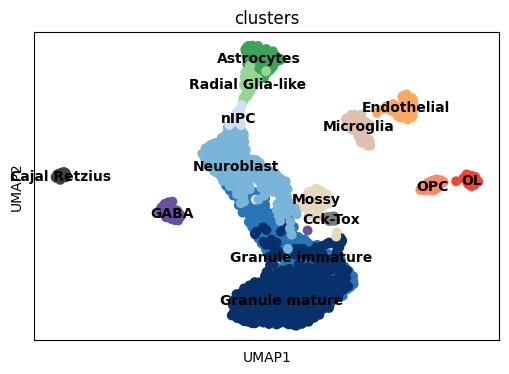

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data', show = False, ax = ax)
plt.savefig(results_path + data_name + 'UMAP_clusters.pdf')
plt.show()


## 6. Setup AnnData for Cell2Fate

As usual in the scvi-tools workflow we register the anndata object:


In [9]:
c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced')


## 7. Initialize the model


In [10]:
max_modules = c2f.utils.get_max_modules(adata)
mod = c2f.Cell2fate_DynamicalModel(adata, n_modules = max_modules)


Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.
Number of Leiden Clusters: 12
Maximal Number of Modules: 13


## 8. View anndata setup


In [15]:
mod.view_anndata_setup()


Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2fate_DynamicalModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'unspliced_label': 'unspliced',
│   'spliced_label': 'spliced',
│   'cluster_label': None
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 2930  │
│      n_vars      │ 3000  │
│     n_batch      │   1   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  unspliced   │ adata.layers['unspliced'] │
│   spliced    │  adata.layers['spliced']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

## 9. Train the model

**Note:** This step can take a while (15-30 minutes depending on your hardware).


In [17]:
mod.train()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 4/500:   1%|          | 3/500 [00:26<1:13:03,  8.82s/it, v_num=1, elbo_train=1.21e+7]

## 10. View training history

We plot training history over multiple windows to effectively assess convergence.


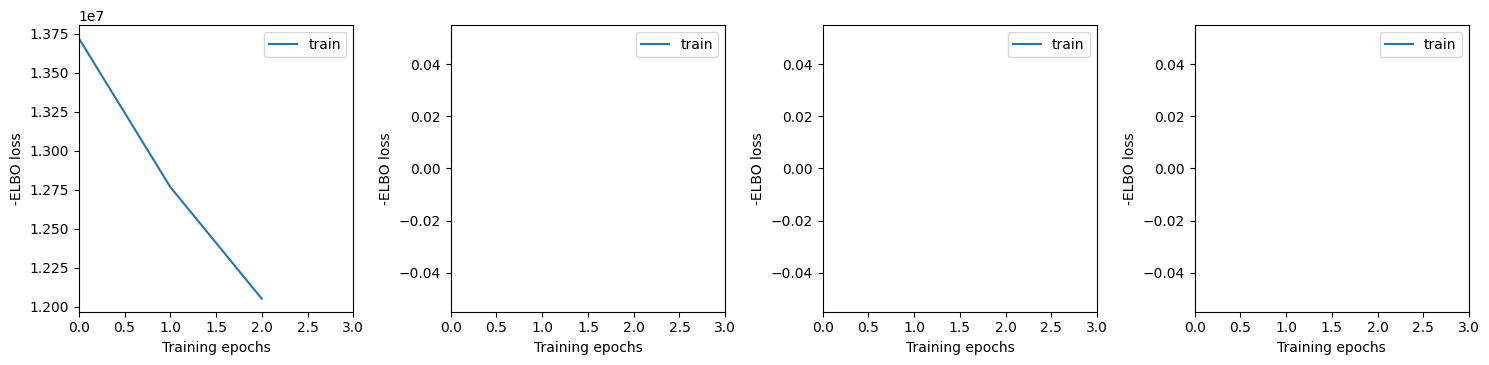

In [18]:
mod.view_history()


## 11. Export posterior to AnnData

Here we export the model posterior to the anndata object:


In [ ]:
adata = mod.export_posterior(adata)


## 12. Visualize differentiation time

One of the interesting parameter posteriors that was saved to the anndata object is the differentiation time:


In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0])
sc.pl.umap(adata, color = ['Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1])
plt.savefig(results_path + data_name + 'UMAP_Time.pdf')
plt.show()


## 13. Compare module activation


In [ ]:
mod.compare_module_activation(adata, chosen_modules = [0,1,2,4,5,6,7,8,9], time_min = 11, time_max = 69,
                         save = results_path + data_name + 'module_activation_comparison.pdf', ncol = 3)


## 14. Gene set enrichment analysis


In [ ]:
tab = mod.gene_set_enrichment_analysis(adata, chosen_modules = [0,1,2,4,5,6,7,8,9], 
                                       background = background,
                                       organism = 'Mouse',
                                       gene_sets = 'GO_Biological_Process_2021',
                                       save = results_path + data_name + 'gene_set_enrichment.csv')


In [ ]:
# Display top results
tab.head(10)


## 15. Plot top marker genes


In [ ]:
mod.plot_top_features(adata, tab, chosen_modules = [0,1,2,4,5,6,7,8,9], mode = 'all genes', n_top_features = 7, process = True,
                      save = results_path + data_name + 'top_genes_plot.pdf')


## 16. Plot top transcription factors


In [ ]:
mod.plot_top_features(adata, tab, chosen_modules =  [0,1,2,4,5,6,7,8,9], mode = 'TFs', n_top_features = 7, process = True,
                      save = results_path + data_name + 'top_TFs_plot.pdf')


## 17. Plot module summary statistics

This plotting function shows marker genes and summary statistics for each module in a convenient format:


In [ ]:
mod.plot_module_summary_statistics_2(adata,
                                 chosen_modules = [4,5,6,7,8,9],
                                 chosen_clusters = ['Radial Glia-like', 'Astrocytes', 'nIPC', 'Neuroblast',
                                                    'Granule immature', 'Granule mature'],
                                 marker_genes = ['Rbm24', 'Palm2', 'Fst', 'Prr16', 'Rgs2', 'Nup160'],
                                 marker_TFs = ['Arid5b', 'Rfx3', 'Zmat4', 'Kdm5d', 'Irf9', 'Tfam'],
                                 save = results_path + data_name + 'module_overview_plot.pdf')


## 18. Plot selected genes

For simply plotting selected genes we can use this function:


In [ ]:
# Clean up some objects that might cause issues
if 'obsp' in adata.__dict__:
    del adata.obsp
if 'Velocity_graph' in adata.uns:
    del adata.uns['Velocity_graph']

mod.plot_genes(adata,
           chosen_clusters = ['Radial Glia-like', 'Astrocytes', 'nIPC', 'Neuroblast',
                                                    'Granule immature', 'Granule mature'],
           marker_genes = ['Rapgef5', 'Moxd1', 'Prr16', 'Rpa3', '1700048O20Rik', 'Spg11', 'Ntng1'],
           save = results_path + data_name + 'additional_module_genes_plot.pdf')


## 19. Save results

Optionally save the processed AnnData object for later use:


In [ ]:
# Save the processed data
adata.write_h5ad(results_path + data_name + '_processed.h5ad')
print(f"Results saved to {results_path}")
